## Practical work in AI

1. Image preprocessing

The images are not sorted in the right way: can't figure out which domain belongs to which images.
I wrote a script to perform sorting based on the domain names that are present in the UNPROCESSED Retouch images.
Now, I have a list of dicts for the source images and a list of dicts for the target images.

2. Image augmentation

    Main problem currently: SVD is slow (0.6 seconds/image just for the decomposition!)
    the entire dataset in batches of 16, dataloading alone takes more than 5 minutes!

    

3. Training

    How many output channels does my network? 2? How many classes do I actually have? i guess 3, since in the paper they use 3 biomarkers
       

In [1]:
import numpy as np

from pathlib import Path
import os
from typing import *
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import monai
from monai.networks.nets import BasicUNetPlusPlus
from monai.transforms import *
from monai.config.type_definitions import KeysCollection

import albumentations as A

import wandb

# Imports from local files
from transforms import *
from dataset import OCTDatasetPrep, MakeDataset
from utils import *


# Set random seed
np.random.seed(99)
torch.manual_seed(99)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


True

## Paths to the data

In [10]:
class Config():

    def __init__(self):

        # paths
        # directory where img folders are still sorted by domain (but unprocessed OCT images)
        self.name_dir = Path(Path.cwd() / 'data/RETOUCH/TrainingSet-Release/') 
        # already processed OCT images but unsorted by domain (sorting happens in dataset class)
        self.train_dir = Path(Path.cwd() / 'data/Retouch-Preprocessed/train') 
        self.model_path = Path(Path.cwd() / 'models')


        self.source_domains = ['Spectralis', 'Topcon', 'Cirrus']


        # transforms
        self.train_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']), # if SVDNA should not be performed, uncomment this and comment the following two lines
                                        #SVDNA(keys=['img'], histogram_matching_degree=.5),
                                        #CustomImageLoader(keys=['label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        #Lambdad(keys=['img', 'label', 'masks'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),  # -1 to 1 scaling
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 1024]),
                                        RandZoomd(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], prob=0.3, min_zoom=0.5, max_zoom=1.5),
                                        RandAxisFlipd(keys=["img", "label", 'masks'], prob=0.3),
                                        RandAffined(keys=["img", "label", 'masks'], 
                                                    prob=0.3, 
                                                    shear_range=[0, 0],
                                                    translate_range=[0, 0],
                                                    rotate_range=[0, 0],
                                                    mode=["bilinear", "nearest", "nearest"], 
                                                    padding_mode="zeros"),      
                                        #Debugging(keys=['img', 'label', 'masks']),
                                        ])


        self.val_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 1024]),
                                    ])
        
        
        self.test_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 1024]),
                                    ])

        # device
        if torch.backends.mps.is_available():
            self.device = 'mps'
        elif torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        # models
        self.model_parameters_unet = {
            'spatial_dims': 2,
            'in_channels': 1,
            'out_channels': 4,
            'channels': (16, 32, 64, 128, 256),
            'strides': (2, 2, 2, 2),
            'num_res_units': 2,
            'bias': False,
            'dropout':0.1
        }


        self.model_parameters_unetpp = {
            'spatial_dims': 2,
            'out_channels': 4,
            'features': (32, 32, 64, 128, 256, 32)
        }


        # hyperparams
        self.batch_size = 1
        #self.lr = 1e-2 # hardcoded into optimizer for correct LR scheduling
        self.epochs = 100




In [11]:
# leftover transforms I keep for later
'''
    #GetMaskPositions(keys=['masks'], target_keys=["mask_positions"]), #We get the layer position, but on the original height
    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),

    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),
    #Lambdad(keys=['mask_positions'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions
    #Lambdad(keys=['img'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), 
'''

'\n    #GetMaskPositions(keys=[\'masks\'], target_keys=["mask_positions"]), #We get the layer position, but on the original height\n    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),\n\n    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),\n    #Lambdad(keys=[\'mask_positions\'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions\n    #Lambdad(keys=[\'img\'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), \n'

## Initialize Config

In [12]:
cfg = Config()

Training set: 3507
Validation set: 1001
Test set: 500


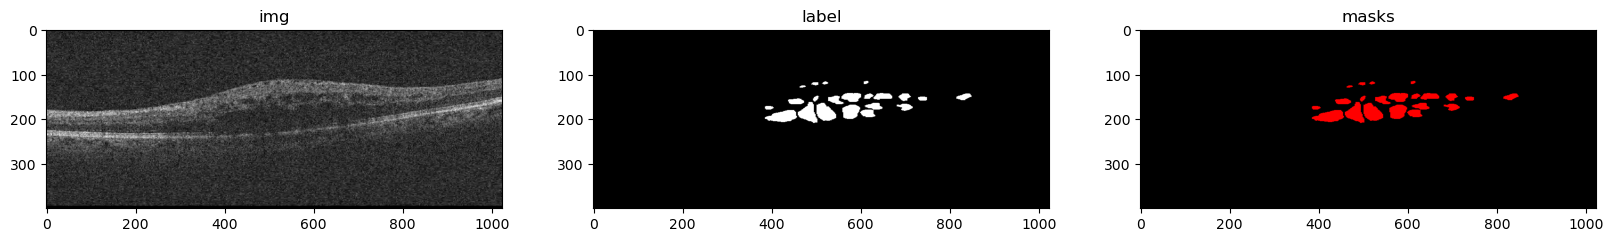

Sample 1 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


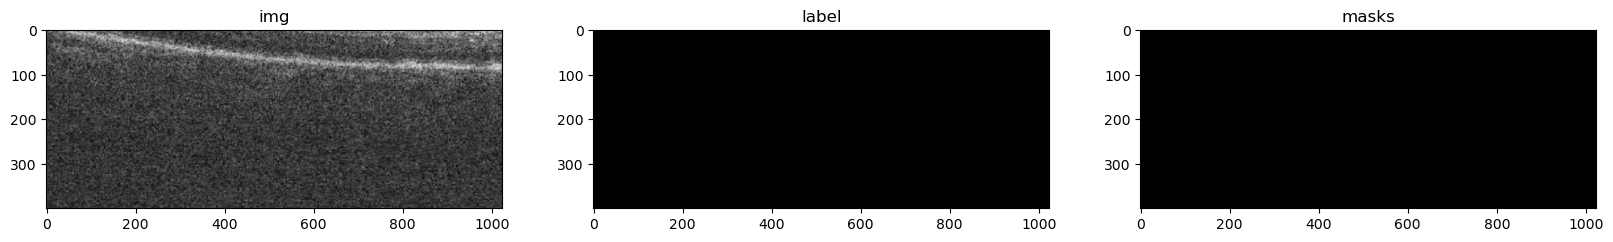

Sample 2 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


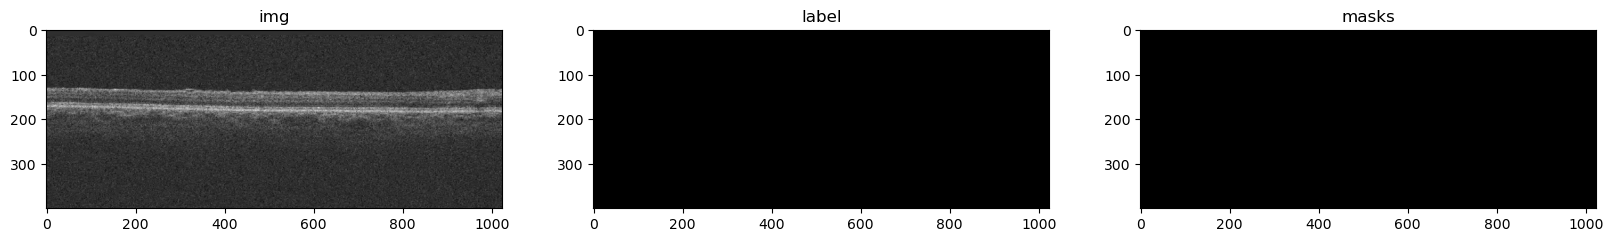

Sample 3 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


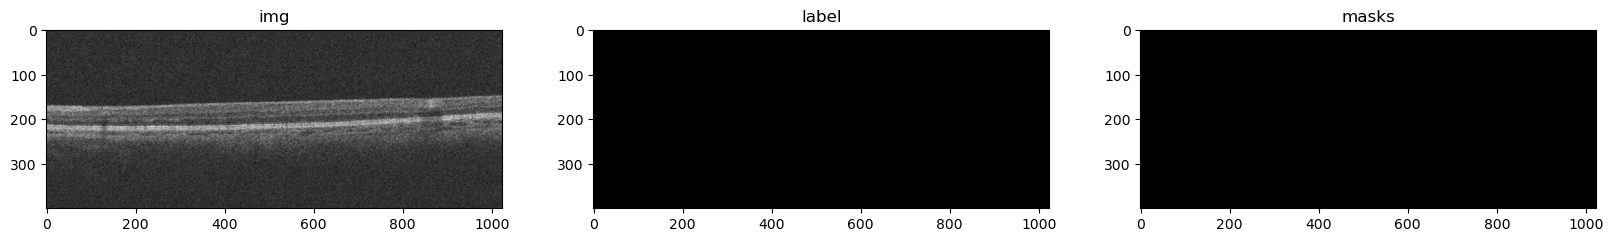

Sample 4 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


In [13]:
print_some_imgs = True

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)
    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape, 
              "\nMasks: ", sample['masks'].shape)



## Architecture, dataset, loss function, optimizer

In [14]:
if not os.path.isdir('models'):
    os.mkdir('models')

if not os.path.isdir('val_predictions'):
    os.mkdir('val_predictions')


print("Device: ", cfg.device)


#model = monai.networks.nets.UNet(**cfg.model_parameters_unet)
model = BasicUNetPlusPlus(**cfg.model_parameters_unetpp)

model = model.to(cfg.device)


#include background is important: we don't want the large amount of background pixels to dominate the loss
criterion = monai.losses.DiceLoss(sigmoid=True, include_background=False) 
optimizer = optim.Adam(model.parameters(), lr=5e-2)


# plotting LR at bottom of the notebook
start_lr = 1
end_lr = 1

scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=1e-6) # cycle 7 times during training

scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs


train_data, val_data, _ = OCTDatasetPrep(cfg.train_dir).get_datasets(dataset_split=[0.7, 0.2, 0.1])

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
#test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
#est_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)


Device:  mps
BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
Training set: 3507
Validation set: 1001
Test set: 500


## Run the thing

In [15]:
#model = load_model(model, cfg.model_path / 'model_two_batches.pth')

wandb_config = {
    'batch_size': cfg.batch_size,
    'lr': optimizer.param_groups[0]['lr'],
    'epochs': cfg.epochs,
    'device': cfg.device,
    'model': 'UNet',
    'dataset': 'Retouch',
    'model_parameters': cfg.model_parameters_unet,
}

with wandb.init(project='PracticalWorkinAI', 
                config=wandb_config,
                name='Fixing erros!') as run:
    wandb_config = wandb.config
    
    model = train(model, 
                  train_loader, val_loader, 
                  criterion, optimizer, scheduler, cfg.device, 
                  epochs=cfg.epochs, 
                  save_path= cfg.model_path / 'model_trial.pth')

Training:   0%|          | 0/100 [00:13<?, ?epoch/s]
Traceback (most recent call last):
  File "/var/folders/gq/0ththbw90js42dvy_79_9qt00000gn/T/ipykernel_18269/3946334035.py", line 18, in <module>
    model = train(model,
  File "/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical/utils.py", line 124, in train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
  File "/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical/utils.py", line 31, in train_one_epoch
    loss = criterion(outputs, masks)
  File "/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/monai/losses/dice.py", line 1

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not list

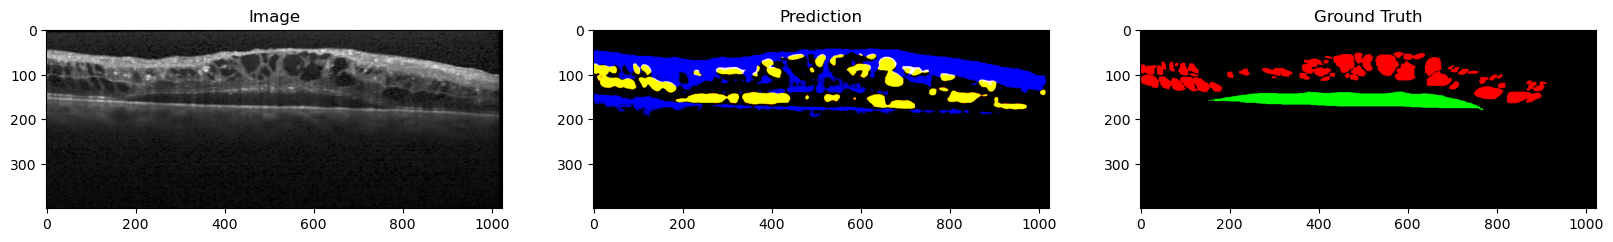

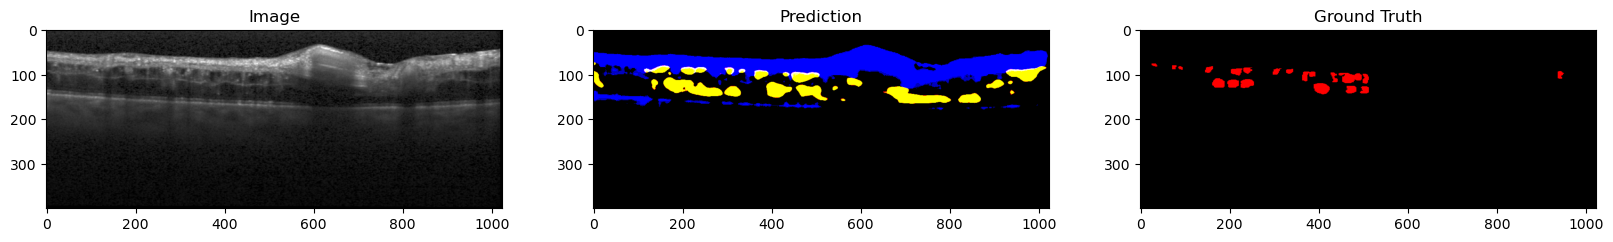

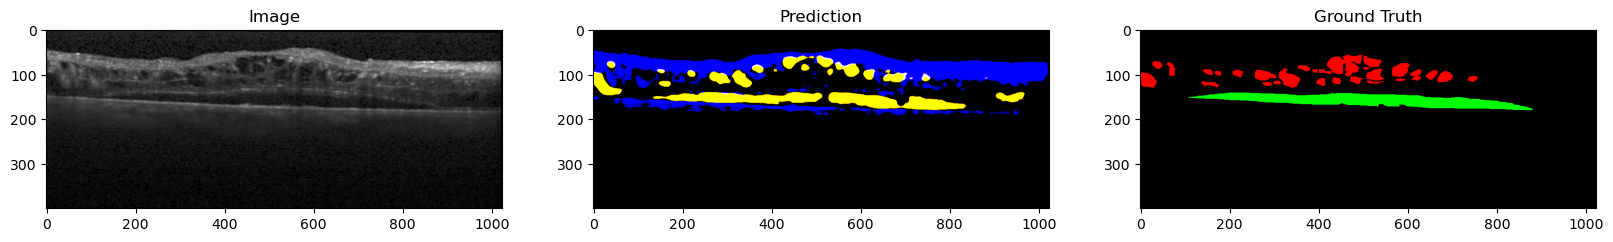

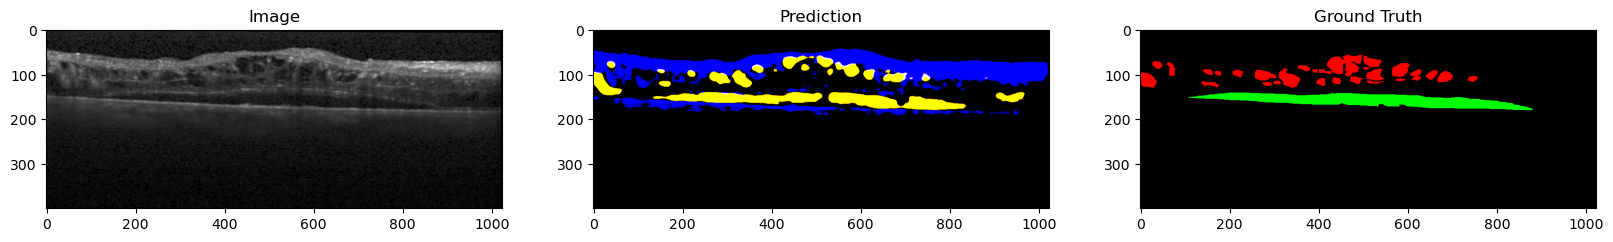

In [29]:
# load saved model and make predictions on random images from the validation set
model = load_model(model, cfg.model_path / 'model_trial.pth')
model.eval()

for i in range(4):
    rand_num = np.random.randint(0, len(val_dataset))
    sample = val_dataset[rand_num]

    img = sample['img'].unsqueeze(0).to(cfg.device)
    mask = sample['masks'].unsqueeze(0).to(cfg.device)

    pred = model(img)
    pred = torch.sigmoid(pred)
    
    # thresholding
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0

    plot_img_label_pred(img, pred, mask)

[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.04939793109008772]
[0.04762072389812426]
[0.04475398023188608]
[0.04093578103172238]
[0.03635003549823881]
[0.031217622834177804]
[0.02578575327157368]
[0.02031606082601419]
[0.01507200130807581]
[0.010306162585314324]
[0.0062480983147733355]
[0.003093271152243439]
[0.000993638004919262]
[5.033080265742518e-05]
[0.00030878532929185345]
[0.0017565527410366554]
[0.004323899183423093]
[0.007887164625335742]
[0.01227471912694858]
[0.0172752296491235]
[0.022647839221193792]
[0.028133768172490806]
[0.03346877863717216]
[0.03839590196107742]
[0.042677815976273105]
[0.046108275973587645]
[0.04852204878347117]
[0.0498028714755113]
[0.04988905133409472]
[0.04877643737912073]
[0.04651862030408512]
[0.04322435120122162]
[0.039052303404614366]
[0.03420342975484062]
[0.02891128340877

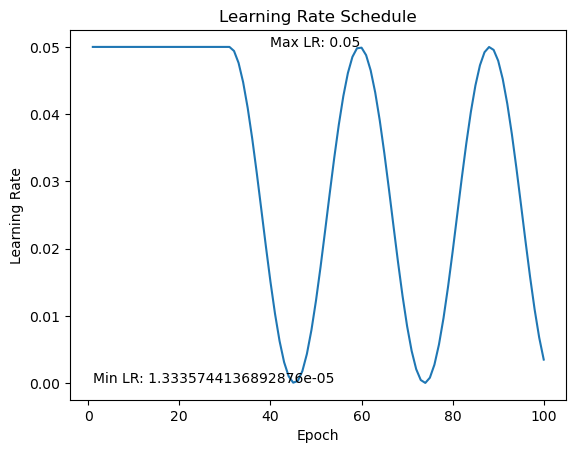

In [28]:
def plot_lr(optimizer, scheduler, num_steps):
    
    lr_values = []

    for i in range(num_steps):
        lr = scheduler.get_last_lr()
        print(lr)
        lr_values.append(lr)
        optimizer.step()
        scheduler.step()

    # Plot the learning rate values
    plt.plot(range(1, num_steps+1), lr_values)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')

    # Add the maximum and minimum learning rate values
    max_lr = max(lr_values)[0]
    min_lr = min(lr_values)[0]

    plt.text(40, max_lr, f'Max LR: {max_lr}')
    plt.text(1, min_lr, f'Min LR: {min_lr}')

    plt.show()

model = monai.networks.nets.UNet(**cfg.model_parameters_unet)
optimizer = optim.Adam(model.parameters(), lr=5e-2)


start_lr = 1
end_lr = 1

scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=1e-6) # cycle 7 times during training

scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs

plot_lr(optimizer, scheduler, 100)